<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

# Quantization Aware Training YoloNAS on Custom Dataset



**Background**: Our research team developed a new deep learning architecture that competes with YOLOv8 using our efficient AutoNAC algorithm.
The new model, named YoloNAS, incorporates quantization-aware RepVGG blocks into the model architecture to ensure compatibility with Post-Training Quantization, making it more flexible and usable for different hardware configurations.


In this tutorial, we will demonstrate how to fine-tune the small variant of the YoloNAS, YoloNAS_S on a custom dataset: the [RF Soccer Players Dataset](https://universe.roboflow.com/roboflow-100/soccer-players-5fuqs) .

0. Installations and dataset setup.
1. Initialize train and validation dataloaders.
2. Define training hyper-parameters.
3. Instantiate a pre-trained YoloNAS_S model and launch training.
4. Run prediction on a real world input.
5. Load the best checkpoint from 3., perform post-training quantization and quantization-aware training.


Prerequisites:
- QAT/PTQ tutorials: [classification notebook](https://github.com/Deci-AI/super-gradients/blob/master/tutorials/PTQ_and_QAT_for_classification.ipynb), [Thorough tutorial](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ptq_qat.md)
- Training object detection models in SG: [Transfer learning notebook](https://bit.ly/3SkMohx).

It is also recommended to see the QAT/PTQ [tutorial](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj125-xvIv_AhVZhP0HHWQnCZYQFnoECBYQAQ&url=https%3A%2F%2Fwww.nvidia.com%2Fen-us%2Fon-demand%2Fsession%2Fgtcspring21-s31653%2F&usg=AOvVaw1i_93iFvK5HJDm_5-SXyMN) from Nvidia.

In [1]:
!pip install -qq super-gradients == 3.4.0 pytorch-quantization == 2.1.2 datasets[vision]  --extra-index-url https: // pypi.ngc.nvidia.com

ERROR: Invalid requirement: '=='


## Step 0: Dataset Setup

In [2]:
from datasets import load_dataset

dataset = load_dataset("cppe-5")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [4]:
dataset["train"].features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'], id=None)}, length=-1, id=None)}

In [5]:
CLASS_NAMES = dataset["train"].features["objects"].feature["category"].names
NUM_CLASSES = len(CLASS_NAMES)

In [6]:
from tqdm import tqdm
import cv2
import numpy as np
import json
import os


def convert_hf_to_coco(dataset_split, output_images_directory, output_annotation_json):
    class_names = dataset["train"].features["objects"].feature["category"].names

    coco_annotation = {
        "images": [],
        "annotations": [],
        "categories": [{"supercategory": name, "name": name, "id": category_id} for category_id, name in enumerate(class_names)],
    }

    os.makedirs(output_images_directory, exist_ok=True)

    annotation_id = 1

    for sample in tqdm(dataset_split):
        image_id = sample["image_id"]
        image = np.array(sample["image"])

        objects = sample["objects"]
        areas = objects["area"]
        bboxes = objects["bbox"]  # XYWH
        category_ids = objects["category"]

        for object_area, object_bbox, object_category in zip(areas, bboxes, category_ids):
            coco_annotation["annotations"].append(
                {
                    "id": annotation_id,
                    "category_id": object_category,
                    "area": float(object_area),
                    "iscrowd": 0,
                    "image_id": image_id,
                    "bbox": list(map(int, object_bbox)),
                }
            )
            annotation_id += 1

        filename = f"{image_id}.jpg"
        output_image_path = os.path.join(output_images_directory, filename)
        cv2.imwrite(output_image_path, image[..., ::-1])  # RGB to BGR

        coco_annotation["images"].append({"file_name": filename, "height": image.shape[0], "width": image.shape[1], "id": image_id})

    with open(output_annotation_json, "w") as f:
        json.dump(coco_annotation, f)


convert_hf_to_coco(dataset["train"], "cppe-5-coco/images/train", "cppe-5-coco/train_annotations.coco.json")
convert_hf_to_coco(dataset["test"], "cppe-5-coco/images/valid", "cppe-5-coco/valid_annotations.coco.json")

100%|██████████| 29/29 [00:00<00:00, 33.04it/s]


# Installations

## Step 1: Initialize train and validation dataloaders.

Next, we instantiate torch DataLoader objects, one for training and one for validation which will be used for our our regular (non QAT training).

Notice how we use SG's dataloaders.get in order to initialize the data loaders, as it comes in handy when wanting to simplify the initialization of components such as the Sampler. We also use the "min_samples" option to truncate the dataset since it is a relatively small.


In [7]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionMosaic,
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN
from super_gradients.training import dataloaders
from super_gradients.training.datasets.datasets_utils import worker_init_reset_seed

train_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/train",
    json_annotation_file="train_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionMosaic(prob=1.0, input_dim=(640, 640)),
        DetectionRandomAffine(degrees=0.0, scales=(0.5, 1.5), shear=0.0, target_size=(640, 640), filter_box_candidates=False, border_value=128),
        DetectionHSV(prob=1.0, hgain=5, vgain=30, sgain=30),
        DetectionHorizontalFlip(prob=0.5),
        DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

valid_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/valid",
    json_annotation_file="valid_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

trainset = COCOFormatDetectionDataset(**train_dataset_params)
valset = COCOFormatDetectionDataset(**valid_dataset_params)

Indexing dataset annotations:  64%|██████▍   | 638/1000 [00:00<00:00, 3190.31it/s]

In [8]:
from torch.utils.data import DataLoader

train_dataloader_params = {
    "shuffle": True,
    "batch_size": 16,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed,
    "num_workers": 4,
    "persistent_workers": True,
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": 32,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed,
    "num_workers": 4,
    "persistent_workers": True,
}

train_loader = DataLoader(trainset, **train_dataloader_params)
valid_loader = DataLoader(valset, **val_dataloader_params)

#Step 2: Defining training hyperparameters

In [9]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "warmup_initial_lr": 1e-6,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "lr_warmup_epochs": 3,
    "warmup_mode": "LinearEpochLRWarmup",
    "optimizer_params": {"weight_decay": 0.0001},
    "ema": True,
    "ema_params": {"beta": 25, "decay_type": "exp"},
    "max_epochs": 30,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=NUM_CLASSES, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
    "metric_to_watch": "mAP@0.50",
}

# Step 3: Instantiate a pre-trained YoloNAS_S and launch training

We instantiate a YoloNAS_S model, pre-trained on the [COCO detection dataset](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj23aGooYv_AhUTh_0HHblrAYsQFnoECAkQAQ&url=https%3A%2F%2Fcocodataset.org%2F&usg=AOvVaw2uf7n84Wuno9qgkHK-zOGp).
Notice we specify num_classes which is different from the 80 classes of COCO, which results in replacing the classification branch of our model's head.

In [10]:
from super_gradients.training import Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import models

trainer = Trainer(experiment_name="yolo_nas_s_cppe-5", ckpt_root_dir="experiments")
model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, pretrained_weights="coco")
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

Validating epoch 30:   0%|          | 0/1 [00:00<?, ?it/s]


# Step 4: Run prediction on a real world input.

Now, lets see our trained model in action. We load the best checkpoint from step 3, and simply call predict on a real-world image.

In [11]:
model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
trainer.test(model=model, test_loader=valid_loader)

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'PPYoloELoss/loss_cls': 0.7016933,
 'PPYoloELoss/loss_iou': 0.38893014,
 'PPYoloELoss/loss_dfl': 0.424674,
 'PPYoloELoss/loss': 1.5152977,
 'Precision@0.50': 0.13852837681770325,
 'Recall@0.50': 0.9655271768569946,
 'mAP@0.50': 0.9076470136642456,
 'F1@0.50': 0.24065318703651428,
 'AP@0.50_Coverall': 0.8988052010536194,
 'AP@0.50_Face_Shield': 0.9937467575073242,
 'AP@0.50_Gloves': 0.8578688502311707,
 'AP@0.50_Goggles': 0.8784725666046143,
 'AP@0.50_Mask': 0.9093416333198547}

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


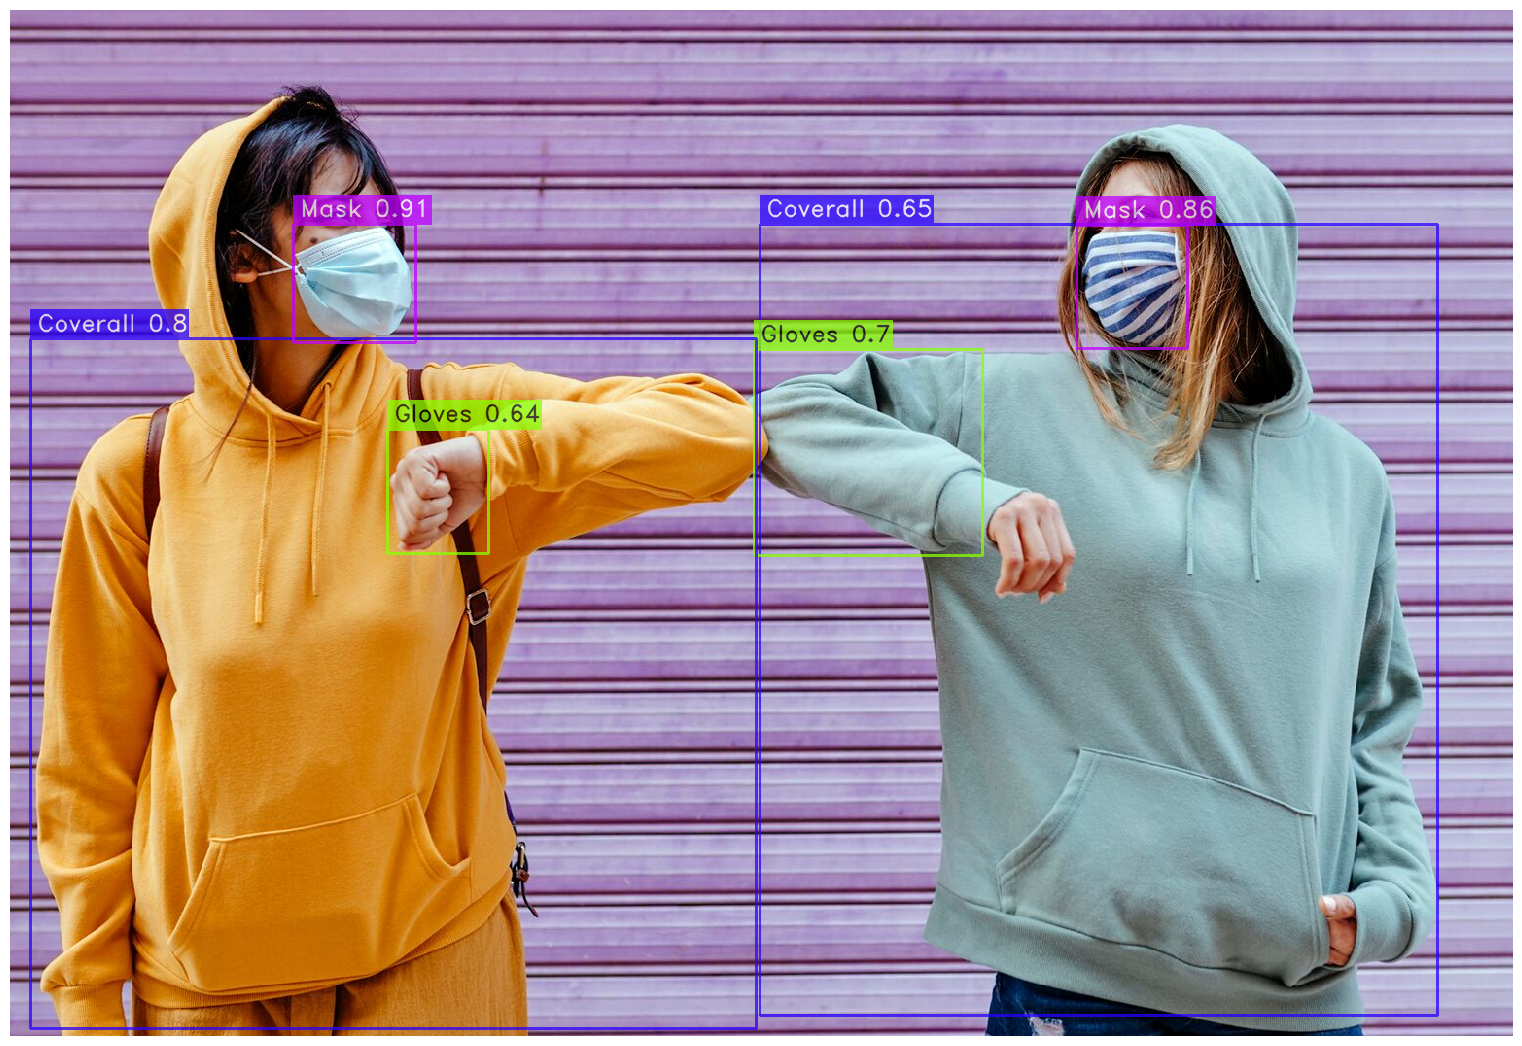

In [12]:
prediction = model.predict(
    "https://dam.northwell.edu/m/1df848c4c688c906/Drupal-NEWS_Wearing-a-mask-is-the-simplest-way-to-combat-COVID-19.jpg", fuse_model=False
)

prediction.show()

# Launch quantization-aware training

Since all local variables are lost, we define again `train_params, train_dataset_params, val_dataset_params, train_dataloader_params, val_dataloader_params`.

Next, we call `modify_params_for_qat`, which will manipulate these configurations according to some best practices for QAT. For example, we turn off augmentations for the trainset. Alll manipulations being done are printed to the screen the for the user's notice.

Finally, after we instantiate our objects with our modified configurations, we call `trainer.qat(model=net, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader, calib_loader=train_loader)`

Under the hood, the following will occur:
- We will use our `calib_loader` which is set to `train_loader` for calibration, gathering statistics that are used to map our network into Int8 range. This part is what we refer to as "Post-training quantization".
- Next, we validate our PTQ model and export it to ONNX format. 
- The exported PTQ model is saved under our checkpoints directory.
- Finally, we perform quantization aware training with our adapted training parameters - since we originally trained for 10 epochs, the general rule of thumb suggests that we quantization-aware train for 10/10=1 epoch. Again, we export the ONNX model to the checkpoints directory.

In [16]:
import os
from super_gradients.common.object_names import Models
from super_gradients.training import models
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.pre_launch_callbacks import modify_params_for_qat

qat_model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))

qat_train_params, qat_train_dataset_params, qat_valid_dataset_params, qat_train_dataloader_params, qat_val_dataloader_params = modify_params_for_qat(
    train_params, train_dataset_params, valid_dataset_params, train_dataloader_params, val_dataloader_params
)

qat_trainset = COCOFormatDetectionDataset(**qat_train_dataset_params)
qat_valset = COCOFormatDetectionDataset(**qat_valid_dataset_params)

qat_train_loader = DataLoader(qat_trainset, **qat_train_dataloader_params)
qat_valid_loader = DataLoader(qat_valset, **qat_val_dataloader_params)

qat_trainer = Trainer(experiment_name="yolo_nas_s_cppe-5_qat", ckpt_root_dir="experiments")
qat_trainer.qat(model=qat_model, training_params=qat_train_params, train_loader=qat_train_loader, valid_loader=qat_valid_loader, calib_loader=qat_train_loader)

Validating epoch 3: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


In [23]:
Trainer(experiment_name="yolo_nas_s_cppe-5-qat-test", ckpt_root_dir="experiments").test(
    model=qat_model,
    test_loader=valid_loader,
    test_metrics_list=[
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
)

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'Precision@0.50': 0.05936146527528763,
 'Recall@0.50': 0.03947404772043228,
 'mAP@0.50': 0.018292449414730072,
 'F1@0.50': 0.022497592493891716,
 'AP@0.50_Coverall': 0.0568217933177948,
 'AP@0.50_Face_Shield': 0.0010026318486779928,
 'AP@0.50_Gloves': 0.024422889575362206,
 'AP@0.50_Goggles': 0.006726987659931183,
 'AP@0.50_Mask': 0.0024879411794245243}

In [21]:
qat_model._image_processor.processings, qat_model._class_names, qat_model._default_nms_iou, qat_model._default_nms_conf

([<super_gradients.training.processing.processing.ReverseImageChannels at 0x24738f281c0>,
 ['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'],
 0.65,
 0.5)

In [22]:
model._image_processor.processings, model._class_names, model._default_nms_iou, model._default_nms_conf

([<super_gradients.training.processing.processing.ReverseImageChannels at 0x2460c47c4f0>,
 ['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'],
 0.65,
 0.5)

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


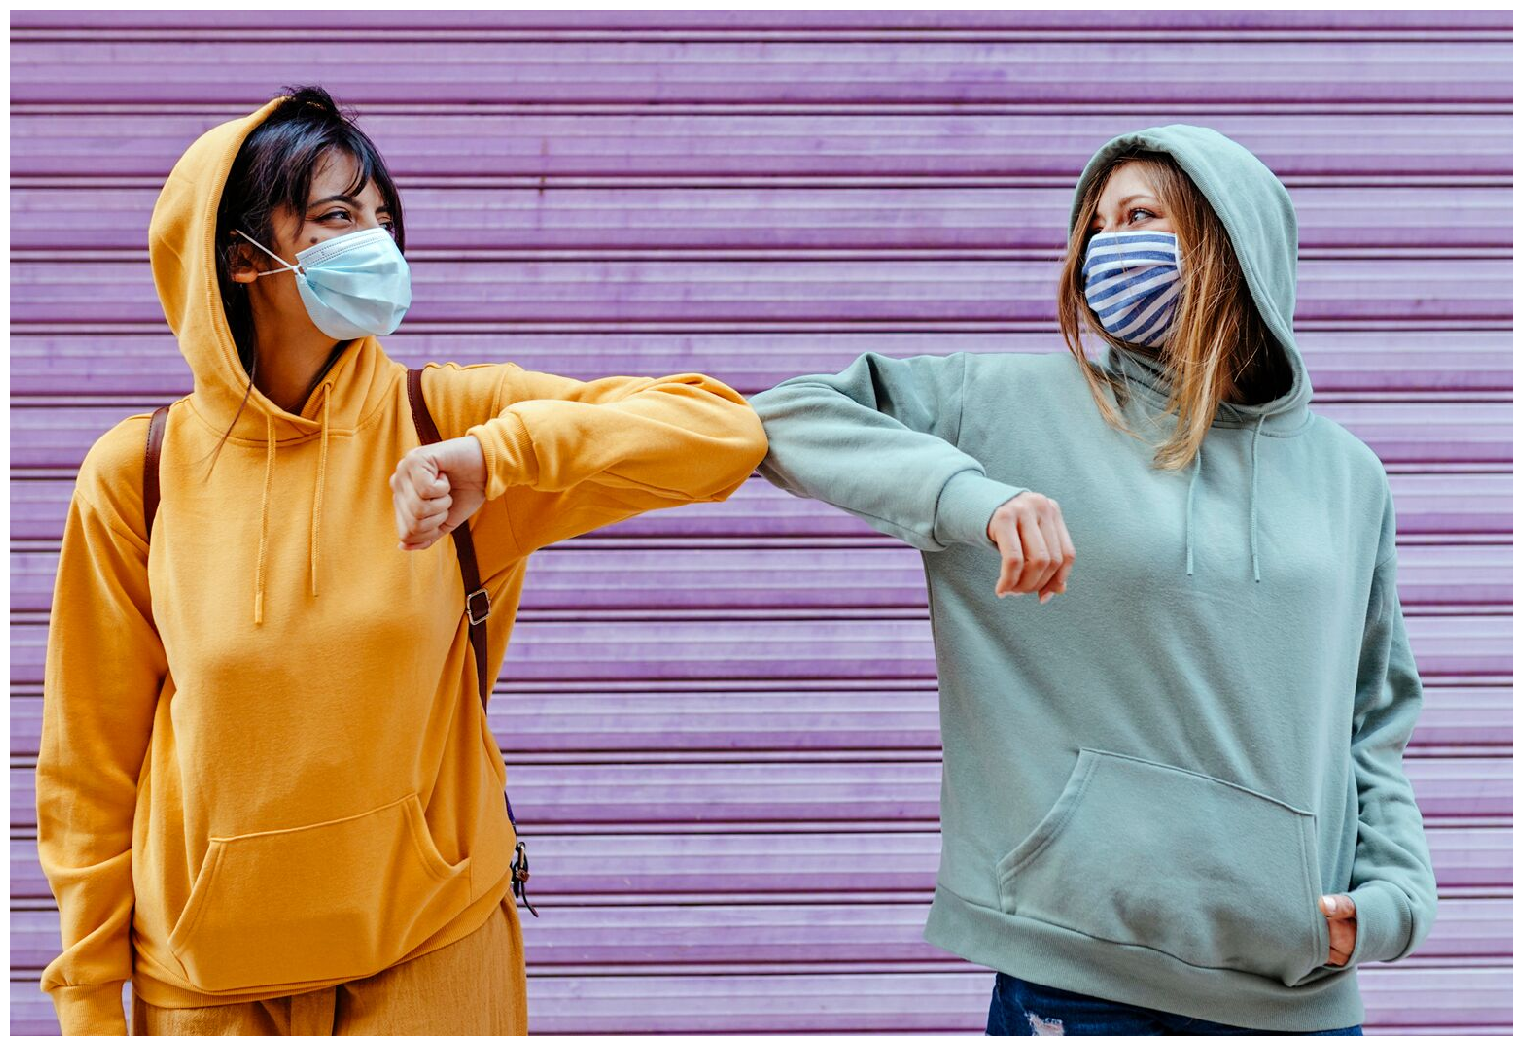

In [15]:
prediction = qat_model.predict(
    "https://dam.northwell.edu/m/1df848c4c688c906/Drupal-NEWS_Wearing-a-mask-is-the-simplest-way-to-combat-COVID-19.jpg", fuse_model=False
)

prediction.show()

# Summary

And there we have it! Our PTQ and QAT checkpoints have been exported to our checkpoints directory under
/content/sg_checkpoints_dir/yolo_nas_s_soccer_players/yolo_nas_s_soccer_players_32x3x640x640_ptq.onnx
and
/content/sg_checkpoints_dir/yolo_nas_s_soccer_players/yolo_nas_s_soccer_players_32x3x640x640_qat.onnx".

If we plug them into [netron](https://netron.app), we can see that new blocks that were not a part of the original network were introduced: the **Quantize/Dequantize** layers -

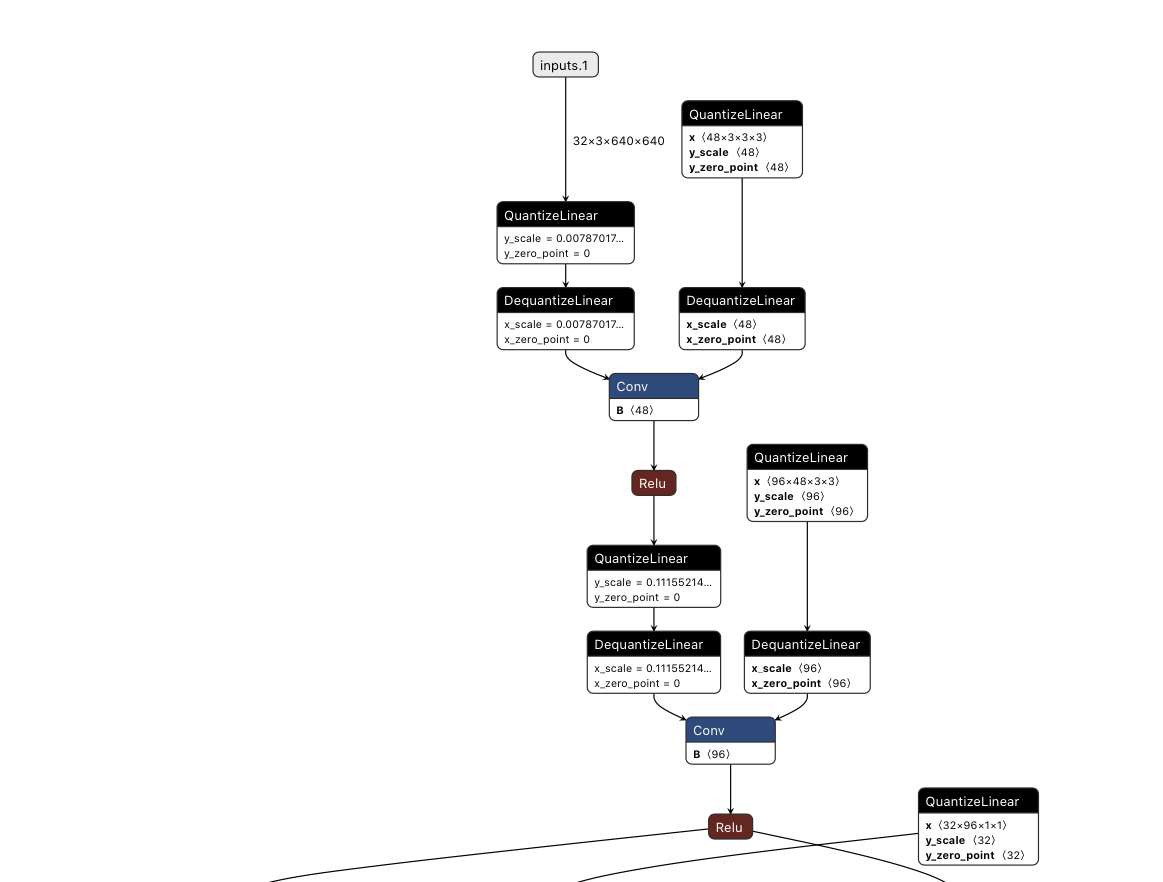

This is expected and a good way to verify that our model is ready to be converted to Int8 using Nvidia's [TesnorRT](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html#deploy-engine):
 We can now use these ONNX files to deploy our newly trained YoloNAS models to production. When building the TRT engine it is important specify that we convert to Int8 (the fake quantized layers in our models will be adapted accordingly), this can be done by running:
`trtexec --fp16 --int8 --onnx=your_yolonas_qat_model.onnx`.

For more information on how to properly export and benchmark YoloNAS, click [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/BenchmarkingYoloNAS.md).